In [104]:
import pandas as pd
from feature_engine.creation import CyclicalFeatures 
data = pd.read_csv('../../data//promice/preprocessed/daily/SCO_L.csv')
data = data.drop(['Unnamed: 0','Surface height from combined measurements DELTA'], axis=1)
#

In [105]:
data.index = pd.to_datetime(data['Datetime'], format='%Y-%m-%d')
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%Y-%m-%d')
#display(data)


In [106]:
def add_features(data):
    df = data.copy()
    df['DayOfYear'] = df['Datetime'].dt.dayofyear
    df['WeekNum'] = df['Datetime'].dt.isocalendar().week.astype(int)
    df['Month'] = df['Datetime'].dt.month
    df['Year'] = df['Datetime'].dt.year
    return df
#df = add_features(data)

import matplotlib.pyplot as plt


df = add_features(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5309 entries, 2008-07-22 00:00:00+00:00 to 2023-02-02 00:00:00+00:00
Data columns (total 24 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   stid                                         5309 non-null   object             
 1   Datetime                                     5309 non-null   datetime64[ns, UTC]
 2   Air pressure (upper boom)                    5266 non-null   float64            
 3   Air temperature (upper boom)                 5266 non-null   float64            
 4   Relative humidity (upper boom) - corrected   5266 non-null   float64            
 5   Specific humidity (upper boom)               5266 non-null   float64            
 6   Wind speed (upper boom)                      4525 non-null   float64            
 7   Wind from direction (upper boom)             4525 non-null   float

In [107]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# Calculating Melt Season Start

In [202]:
# Preprocessing 
data = add_features(data)

#data = data.ffill()
#data = data.bfill()
df = data.copy()

df.index = pd.to_datetime(df['Datetime'], format='%Y-%m-%d')

df['event'] = 0
df['time_to_event'] = 0

# event categorization
unique_years = df['Year'].unique()
events = []
for year in unique_years:
    # Filter data for the current year
    year_data = df[df['Year'] == year]
    event = year_data.loc[year_data['Ablation'] == True].index.min()

    df.loc[df.index == event,['event']] = 1
    df.loc[df.index.year == year, ['time_to_event']] = (year_data.index - event).astype('timedelta64[D]')

pre_processed_df = df

In [203]:
display(df.loc[df['event'] == True])

,stid,Datetime,Air pressure (upper boom),Air temperature (upper boom),Relative humidity (upper boom) - corrected,Specific humidity (upper boom),Wind speed (upper boom),Wind from direction (upper boom),Downwelling shortwave radiation - corrected,Upwelling shortwave radiation - corrected,...,Albedo,Cloud cover,Ablation,Melting Season,DayOfYear,WeekNum,Month,Year,event,time_to_event
Datetime,,,,,,,,,,,,,,,,,,,,,
2008-07-22 00:00:00+00:00,SCO_L,2008-07-22 00:00:00+00:00,948.567773,3.056455,83.017773,4.149818,2.281800,91.300100,95.482409,30.211909,...,0.322083,0.826682,True,beginning,204,30,7,2008,1,0.0
2009-06-02 00:00:00+00:00,SCO_L,2009-06-02 00:00:00+00:00,966.884750,2.325417,60.709875,2.820500,2.281800,91.300100,310.896208,167.770583,...,0.538692,0.210042,True,beginning,153,23,6,2009,1,0.0
2010-06-03 00:00:00+00:00,SCO_L,2010-06-03 00:00:00+00:00,959.367750,0.991542,75.205292,3.171958,2.281800,91.300100,345.727667,170.349792,...,0.496571,0.232792,True,beginning,154,22,6,2010,1,0.0
2011-06-13 00:00:00+00:00,SCO_L,2011-06-13 00:00:00+00:00,971.155875,1.098708,83.272208,3.530708,0.666957,164.587522,321.044708,111.304083,...,0.351538,0.583208,True,beginning,164,24,6,2011,1,0.0
2012-06-06 00:00:00+00:00,SCO_L,2012-06-06 00:00:00+00:00,965.258750,-0.331208,87.008375,3.334083,0.811435,213.362174,240.586250,111.646500,...,0.467077,0.841833,True,beginning,158,23,6,2012,1,0.0
2013-06-05 00:00:00+00:00,SCO_L,2013-06-05 00:00:00+00:00,958.930958,7.659125,45.425250,3.082083,3.325792,181.497917,363.300542,154.929333,...,0.425714,0.180292,True,beginning,156,23,6,2013,1,0.0
2014-06-03 00:00:00+00:00,SCO_L,2014-06-03 00:00:00+00:00,959.435500,0.347250,68.097958,2.755583,2.151417,123.275333,379.527125,189.150500,...,0.486583,0.215458,True,beginning,154,23,6,2014,1,0.0
2015-05-15 00:00:00+00:00,SCO_L,2015-05-15 00:00:00+00:00,950.025208,-4.130500,65.367167,1.840375,1.958208,170.940250,273.073250,206.445250,...,0.755917,0.466625,True,beginning,135,20,5,2015,1,0.0
2016-05-01 00:00:00+00:00,SCO_L,2016-05-01 00:00:00+00:00,957.021958,-0.414458,66.938833,2.569167,6.601292,101.399250,187.336917,140.167042,...,0.756333,0.678833,True,beginning,122,17,5,2016,1,0.0


In [185]:
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

df = pre_processed_df

train_columns = df.drop(['stid','Datetime','Ablation','Melting Season','WeekNum','Month','Year','time_to_event','event','DayOfYear'],axis=1).columns

scaler = MinMaxScaler()
df[train_columns] = scaler.fit_transform(df[train_columns])

def create_lagged_features(df, n_lags):
    lagged_df = pd.DataFrame()
    
    for i in df.columns:
        for j in range(1,n_lags+1):
            lagged_df[f'{i}_lag_{j}'] = df[i].shift(j).copy()
    return lagged_df.copy(), lagged_df.columns


n_lags = 7

lagged_features, lagged_columns = create_lagged_features(df[train_columns], n_lags)

max_year, min_year = df['Year'].max(), df['Year'].min()
df = df.loc[(df['Year'] != min_year) & (df['Year'] != max_year)]
df = df.loc[df['Month'] <= 6]

features = pd.merge(df[train_columns], lagged_features, how='left',left_index=True,right_index=True)

target = df[['time_to_event','event']].copy()

features.dropna(inplace=True)
target.dropna(inplace=True)

common_index = features.index.intersection(target.index)
features = features.loc[common_index]
target = target.loc[common_index]
print(features.shape)

(2537, 128)


In [186]:
unique_years = df['Year'].unique()
train_years, test_years = train_test_split(unique_years, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=True, random_state=42)

train = df.loc[df['Year'].isin(train_years)].index
test = df.loc[df['Year'].isin(test_years)].index
X_train = features.loc[features.index.isin(train)]
y_train = target.loc[target.index.isin(train)]
X_test = features.loc[features.index.isin(test)]
y_test = target.loc[features.index.isin(test)]

display(y_test.head(5))

,time_to_event,event
Datetime,,
2009-01-01 00:00:00+00:00,-152.0,0
2009-01-02 00:00:00+00:00,-151.0,0
2009-01-03 00:00:00+00:00,-150.0,0
2009-01-04 00:00:00+00:00,-149.0,0
2009-01-05 00:00:00+00:00,-148.0,0


In [187]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score


xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=3,
    min_child_weight=1,
    learning_rate=0.1,
    n_estimators=60,
    subsample=1.0,
    colsample_bytree=0.7,
    reg_alpha=0.5,
    reg_lambda=0.1,
    early_stopping_rounds=20)


#xgb_model.fit(X_train, y_train['time_to_event'])

xgb_model.fit(X_train, y_train['time_to_event'],
        eval_set=[(X_train, y_train['time_to_event']),(X_test,y_test['time_to_event'])],
        verbose=10)

xgb_pred_train = xgb_model.predict(X_train)
xgb_pred_test = xgb_model.predict(X_test)

print("XGBoost MAE - Train:", mean_absolute_error(y_train['time_to_event'], xgb_pred_train))
print("XGBoost MAE - Test:", mean_absolute_error(y_test['time_to_event'], xgb_pred_test))
print("XGBoost MSE - Train:", mean_squared_error(y_train['time_to_event'], xgb_pred_train))
print("XGBoost MSE - Test:", mean_squared_error(y_test['time_to_event'], xgb_pred_test))
print("XGBoost R2 - Train:", r2_score(y_train['time_to_event'], xgb_pred_train))
print("XGBoost R2 - Test:", r2_score(y_test['time_to_event'], xgb_pred_test))

results = y_test['time_to_event'].to_frame()
results['xgb_pred'] = xgb_pred_test
results = results.sort_index()
#display(results)

[0]	validation_0-rmse:69.50469	validation_1-rmse:68.51033
[10]	validation_0-rmse:26.49568	validation_1-rmse:27.16536
[20]	validation_0-rmse:11.97834	validation_1-rmse:15.34965
[30]	validation_0-rmse:6.79625	validation_1-rmse:13.25483
[40]	validation_0-rmse:4.70752	validation_1-rmse:13.44457
[50]	validation_0-rmse:3.73123	validation_1-rmse:14.15048
[54]	validation_0-rmse:3.51601	validation_1-rmse:14.39483
XGBoost MAE - Train: 4.636277189032477
XGBoost MAE - Test: 10.681367013959543
XGBoost MSE - Train: 32.91604752309161
XGBoost MSE - Test: 174.93995328655987
XGBoost R2 - Train: 0.9887392215308788
XGBoost R2 - Test: 0.9392449367608453


XGBoost MAE - Train: 4.636277189032477
XGBoost MAE - Test: 10.681367013959543
XGBoost MSE - Train: 32.91604752309161
XGBoost MSE - Test: 174.93995328655987
XGBoost R2 - Train: 0.9887392215308788
XGBoost R2 - Test: 0.9392449367608453


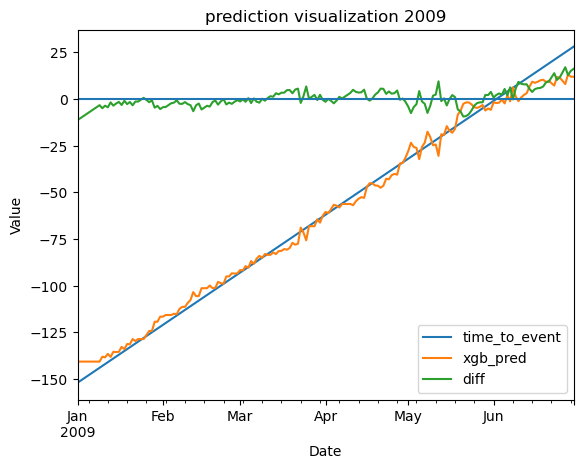

<Axes: title={'center': 'Feature Importance'}>

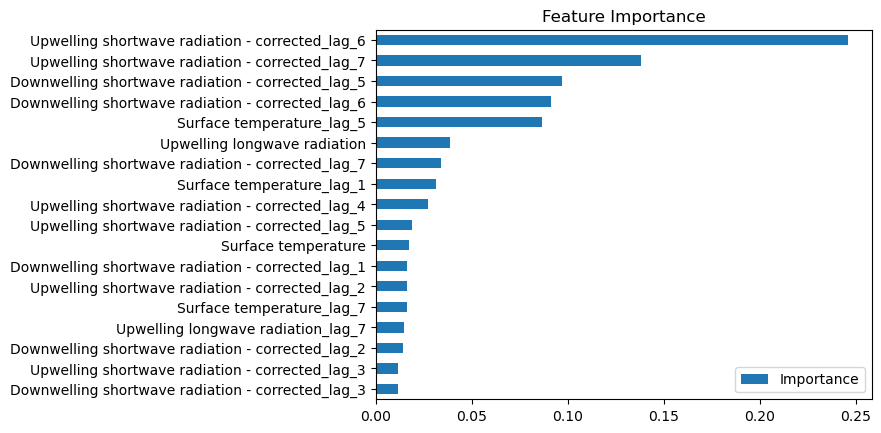

In [188]:
print("XGBoost MAE - Train:", mean_absolute_error(y_train['time_to_event'], xgb_pred_train))
print("XGBoost MAE - Test:", mean_absolute_error(y_test['time_to_event'], xgb_pred_test))
print("XGBoost MSE - Train:", mean_squared_error(y_train['time_to_event'], xgb_pred_train))
print("XGBoost MSE - Test:", mean_squared_error(y_test['time_to_event'], xgb_pred_test))
print("XGBoost R2 - Train:", r2_score(y_train['time_to_event'], xgb_pred_train))
print("XGBoost R2 - Test:", r2_score(y_test['time_to_event'], xgb_pred_test))

results['diff'] = results['time_to_event'] - results['xgb_pred']

sample_year = unique_years[0]
#plotting cyclical_conversion
results.loc[results.index.year == sample_year].plot()
plt.xlabel('Date')
plt.ylabel('Value')
plt.axhline(y=0)
plt.title(f'prediction visualization {sample_year}')
plt.show()

f1 = pd.DataFrame(data=xgb_model.feature_importances_,
        index=xgb_model.feature_names_in_,
        columns=['Importance'])
f1 = f1.loc[f1['Importance'] > 0.01]
f1.sort_values('Importance').plot(kind='barh',title='Feature Importance')

# Calculating melt season end
-------------------------------------


In [194]:
# Preprocessing
# Assume 'add_features' is a function that adds necessary features to the dataset
data = add_features(data)

# Create a copy of the data
df = data.copy()

# Set the DataFrame index to the 'Datetime' column, converting it to a datetime object
df.index = pd.to_datetime(df['Datetime'], format='%Y-%m-%d')

# Initialize 'event' and 'time_to_event' columns with zeros
df['event'] = 0
df['time_to_event'] = 0

# Event categorization
# Get the unique years in the DataFrame
unique_years = df['Year'].unique()
events = []

# Iterate through each unique year
for year in unique_years:
    # Filter data for the current year
    year_data = df[df['Year'] == year]
    
    # Find the last occurrence of ablation (melting) for the current year
    event = year_data.loc[year_data['Ablation'] == True].index.max()

    # Set the 'event' column value to 1 for the day of the event
    df.loc[df.index == event, ['event']] = 1
    
    # Calculate 'time_to_event' for each day in the current year
    df.loc[df.index.year == year, ['time_to_event']] = (year_data.index - event).astype('timedelta64[D]')

# Store the pre-processed DataFrame
pre_processed_df = df


In [198]:
import warnings

# Ignore performance warnings from pandas
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Load pre-processed DataFrame
df = pre_processed_df

# Define the columns used for training
train_columns = df.drop(['stid', 'Datetime', 'Ablation', 'Melting Season', 'WeekNum', 'Month', 'Year', 'time_to_event', 'event', 'DayOfYear'], axis=1).columns

# Scale the training columns using MinMaxScaler
scaler = MinMaxScaler()
df[train_columns] = scaler.fit_transform(df[train_columns])

# Function to create lagged features for a given DataFrame and number of lags
def create_lagged_features(df, n_lags):
    lagged_df = pd.DataFrame()
    
    # For each column in the DataFrame, create lagged features
    for i in df.columns:
        for j in range(1, n_lags + 1):
            lagged_df[f'{i}_lag_{j}'] = df[i].shift(j).copy()
    return lagged_df.copy(), lagged_df.columns

# Define the number of lags
n_lags = 7

# Create lagged features and store their column names
lagged_features, lagged_columns = create_lagged_features(df[train_columns], n_lags)

# Filter the DataFrame by excluding the minimum and maximum years
max_year, min_year = df['Year'].max(), df['Year'].min()
df = df.loc[(df['Year'] != min_year) & (df['Year'] != max_year)]

# Filter the DataFrame to include only months less than or equal to 6
df = df.loc[(df['Month'] >= 5) & (df['Month'] <= 10)]

# Merge the original features with the lagged features
features = pd.merge(df[train_columns], lagged_features, how='left', left_index=True, right_index=True)

# Store the target variables (time_to_event and event)
target = df[['time_to_event', 'event']].copy()

# Drop NaN values from the features and target DataFrames
features.dropna(inplace=True)
target.dropna(inplace=True)

# Retain only rows with common indices in both features and target DataFrames
common_index = features.index.intersection(target.index)
features = features.loc[common_index]
target = target.loc[common_index]

# Print the shape of the final features DataFrame
print(features.shape)


(2576, 128)


In [201]:
display(df.loc[df['event'] == True])

,stid,Datetime,Air pressure (upper boom),Air temperature (upper boom),Relative humidity (upper boom) - corrected,Specific humidity (upper boom),Wind speed (upper boom),Wind from direction (upper boom),Downwelling shortwave radiation - corrected,Upwelling shortwave radiation - corrected,...,Albedo,Cloud cover,Ablation,Melting Season,DayOfYear,WeekNum,Month,Year,event,time_to_event
Datetime,,,,,,,,,,,,,,,,,,,,,
2009-09-12 00:00:00+00:00,SCO_L,2009-09-12 00:00:00+00:00,0.497921,0.819518,0.504062,0.528724,0.207323,0.251244,0.220547,0.148614,...,0.251336,0.281599,True,end,255,37,9,2009,1,0.0
2010-09-15 00:00:00+00:00,SCO_L,2010-09-15 00:00:00+00:00,0.554151,0.833510,0.732304,0.696616,0.118865,0.229733,0.253587,0.133378,...,0.128376,0.608137,True,end,258,37,9,2010,1,0.0
2011-09-14 00:00:00+00:00,SCO_L,2011-09-14 00:00:00+00:00,0.502156,0.748306,0.539405,0.447082,0.269480,0.137784,0.303072,0.165676,...,0.143531,0.130524,True,end,257,37,9,2011,1,0.0
2012-09-05 00:00:00+00:00,SCO_L,2012-09-05 00:00:00+00:00,0.496561,0.737821,0.437225,0.382283,0.351766,0.163710,0.386310,0.230497,...,0.182107,0.182383,True,end,249,36,9,2012,1,0.0
2013-09-12 00:00:00+00:00,SCO_L,2013-09-12 00:00:00+00:00,0.382817,0.625478,0.577416,0.309132,0.278248,0.249361,0.227388,0.280710,...,0.788294,0.725863,True,end,255,37,9,2013,1,0.0
2014-09-18 00:00:00+00:00,SCO_L,2014-09-18 00:00:00+00:00,0.687566,0.687185,0.407339,0.302822,0.350803,0.727123,0.256395,0.178506,...,0.257191,0.191262,True,end,261,38,9,2014,1,0.0
2015-09-08 00:00:00+00:00,SCO_L,2015-09-08 00:00:00+00:00,0.497307,0.751868,0.778984,0.570447,0.057381,0.391421,0.181462,0.156083,...,0.433537,0.772053,True,end,251,37,9,2015,1,0.0
2016-09-14 00:00:00+00:00,SCO_L,2016-09-14 00:00:00+00:00,0.492487,0.784782,0.349103,0.398849,0.281778,0.599069,0.238671,0.163618,...,0.268902,0.208688,True,end,258,37,9,2016,1,0.0
2017-09-12 00:00:00+00:00,SCO_L,2017-09-12 00:00:00+00:00,0.516749,0.718434,0.471676,0.372783,0.438394,0.854180,0.254118,0.190439,...,0.328487,0.179381,True,end,255,37,9,2017,1,0.0


In [199]:
unique_years = df['Year'].unique()
train_years, test_years = train_test_split(unique_years, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=True, random_state=42)

train = df.loc[df['Year'].isin(train_years)].index
test = df.loc[df['Year'].isin(test_years)].index
X_train = features.loc[features.index.isin(train)]
y_train = target.loc[target.index.isin(train)]
X_test = features.loc[features.index.isin(test)]
y_test = target.loc[features.index.isin(test)]

display(y_test.head(5))

,time_to_event,event
Datetime,,
2009-05-01 00:00:00+00:00,-134.0,0
2009-05-02 00:00:00+00:00,-133.0,0
2009-05-03 00:00:00+00:00,-132.0,0
2009-05-04 00:00:00+00:00,-131.0,0
2009-05-05 00:00:00+00:00,-130.0,0


In [192]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score


xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=3,
    min_child_weight=1,
    learning_rate=0.1,
    n_estimators=60,
    subsample=1.0,
    colsample_bytree=0.7,
    reg_alpha=0.5,
    reg_lambda=0.1,
    early_stopping_rounds=20)


#xgb_model.fit(X_train, y_train['time_to_event'])

xgb_model.fit(X_train, y_train['time_to_event'],
        eval_set=[(X_train, y_train['time_to_event']),(X_test,y_test['time_to_event'])],
        verbose=10)

xgb_pred_train = xgb_model.predict(X_train)
xgb_pred_test = xgb_model.predict(X_test)

print("XGBoost MAE - Train:", mean_absolute_error(y_train['time_to_event'], xgb_pred_train))
print("XGBoost MAE - Test:", mean_absolute_error(y_test['time_to_event'], xgb_pred_test))
print("XGBoost MSE - Train:", mean_squared_error(y_train['time_to_event'], xgb_pred_train))
print("XGBoost MSE - Test:", mean_squared_error(y_test['time_to_event'], xgb_pred_test))
print("XGBoost R2 - Train:", r2_score(y_train['time_to_event'], xgb_pred_train))
print("XGBoost R2 - Test:", r2_score(y_test['time_to_event'], xgb_pred_test))

results = y_test['time_to_event'].to_frame()
results['xgb_pred'] = xgb_pred_test
results = results.sort_index()
#display(results)

[0]	validation_0-rmse:69.50469	validation_1-rmse:68.51033
[10]	validation_0-rmse:26.49568	validation_1-rmse:27.16536
[20]	validation_0-rmse:11.97834	validation_1-rmse:15.34965
[30]	validation_0-rmse:6.79625	validation_1-rmse:13.25483
[40]	validation_0-rmse:4.70752	validation_1-rmse:13.44457
[50]	validation_0-rmse:3.73123	validation_1-rmse:14.15048
[53]	validation_0-rmse:3.55509	validation_1-rmse:14.40961
XGBoost MAE - Train: 4.636277189032477
XGBoost MAE - Test: 10.681367013959543
XGBoost MSE - Train: 32.91604752309161
XGBoost MSE - Test: 174.93995328655987
XGBoost R2 - Train: 0.9887392215308788
XGBoost R2 - Test: 0.9392449367608453


In [ ]:
print("XGBoost MAE - Train:", mean_absolute_error(y_train['time_to_event'], xgb_pred_train))
print("XGBoost MAE - Test:", mean_absolute_error(y_test['time_to_event'], xgb_pred_test))
print("XGBoost MSE - Train:", mean_squared_error(y_train['time_to_event'], xgb_pred_train))
print("XGBoost MSE - Test:", mean_squared_error(y_test['time_to_event'], xgb_pred_test))
print("XGBoost R2 - Train:", r2_score(y_train['time_to_event'], xgb_pred_train))
print("XGBoost R2 - Test:", r2_score(y_test['time_to_event'], xgb_pred_test))

results['diff'] = results['time_to_event'] - results['xgb_pred']

sample_year = unique_years[0]
#plotting cyclical_conversion
results.loc[results.index.year == sample_year].plot()
plt.xlabel('Date')
plt.ylabel('Value')
plt.axhline(y=0)
plt.title(f'prediction visualization {sample_year}')
plt.show()

f1 = pd.DataFrame(data=xgb_model.feature_importances_,
        index=xgb_model.feature_names_in_,
        columns=['Importance'])
f1 = f1.loc[f1['Importance'] > 0.01]
f1.sort_values('Importance').plot(kind='barh',title='Feature Importance')

# Survival analysis